<a href="https://colab.research.google.com/github/jeyoor/iusb-dl/blob/master/dogs_and_cats_functional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dogs and Cats (Functional API)

This future import is used for compatability between Python2 and Python3

See further [here for Python2](https://docs.python.org/2/library/__future__.html) and [here for Python3](https://docs.python.org/3/library/__future__.html)

In [0]:
from __future__ import print_function

Extract training data (requires tarball to be available)

Note that this code snippet is not required when running on csNN.cs.iusb.edu because the data is already available on that server

In [0]:
from six.moves import urllib
import tarfile
urllib.request.urlretrieve('https://github.com/jeyoor/iusb-dl/raw/master/dogs_cats_data_edited.tar.gz', 'dogs_cats_data_edited.tar.gz')
data_tarball = tarfile.open('/content/dogs_cats_data_edited.tar.gz', 'r:gz')
data_tarball.extractall()
data_tarball.close()


Imports... note that the %matplotlib inline directive is not used when running on csNN.cs.iusb.edu

In [0]:
import os
import time as t
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as skmetrics
import skimage.transform as sktransform

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam,SGD
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img

For more information on the meaning of some of the constants below, see these links.

[Keras fit_generator documentation](https://keras.io/models/sequential/#fit_generator)

[StackExchange CrossValidated Question: "Tradeoff batch size vs. number of iterations"](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)

[StackExchange CrossValidated Question: "What is batch size in neural network?"](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network)

Note that Keras can save the model structure and the weights into an hdf5 file

A user-friendly introduction to the hdf5 file format is available [here](https://portal.hdfgroup.org/display/HDF5/Introduction+to+HDF5)

More details on the hdf5 file format are available [here](https://portal.hdfgroup.org/display/HDF5/HDF5)

In [0]:
#create constants
IMAGE_SIZE = (224, 224)
#using 10 epochs for training test, recommend bumping to 100 for real training
EPOCHS = 10
STEPS_PER_EPOCH = 1
NUM_CLASSES = 2
BATCH_SIZE = 32
VALIDATION_STEPS = 32
DATASET_PATH = './dataset'
WEIGHTS_FINAL = 'model-dogcat-functional-final.h5'
#dump full model to disk every 10 epochs
MODEL_SAVER_PERIOD = EPOCHS / 10

Creating data generators 

Note that we are rescaling the image values from 0-255 down to 0-1

Also note that training data generator is augmenting the training data by rescaling, shifting, and shearing it, but the validation data generator is not augmenting

See more about image augmentation [here](https://towardsdatascience.com/image-augmentation-for-deep-learning-histogram-equalization-a71387f609b2)

In [53]:
#create training and validation data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory=DATASET_PATH + '/train',
                                                    target_size=IMAGE_SIZE,
                                                    interpolation='bicubic',
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_generator = validation_datagen.flow_from_directory(directory=DATASET_PATH + '/validation',
                                                              target_size=IMAGE_SIZE,
                                                              interpolation='bicubic',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Set up the CNN model (convolutional layers with max pooling followed by dense layers at the end)

See [this visualizer](https://playground.tensorflow.org/) for another way to play around with various neural network architectures

In [0]:
#Now make our first convolutional layer, 32 filters, 3x3, default stride and padding
inputs = Input(shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],3))
layer1 = Conv2D(32, (3, 3), activation='relu')(inputs)
#Do a max pooling, increase number of filters, but reduce feature map size
layer2 = MaxPooling2D(pool_size=(2,2))(layer1)
#And another convolution/pooling pair
layer3 = Conv2D(64, (3, 3), activation='relu')(layer2)
layer4 = MaxPooling2D(pool_size=(2,2))(layer3)
#Finally another convolutional layer
layer5 = Conv2D(128, (3,3), activation='relu')(layer4)
#Make output of prior convolutional layer 1D for Dense layers
layer6 = Flatten()(layer5)
#Dense layers form the classifier using input from convolutional layers
layer7 = Dense(32, activation='sigmoid')(layer6) #Could be 'relu' activation
layer8 = Dense(2, activation='softmax')(layer7) #Softmax represents outputs as probabilites

Instantiate the model and print a summary of the layers.

For more recent state of the art results on tasks like ImageNet, the "[Papers With Code](https://paperswithcode.com/sota/image-classification-on-imagenet)" site is a good resource.


In [55]:
#Use Adam optimizer (instead of plain SGD), set learning rate to explore.
adam = Adam(lr=.001)

#instantiate model
model = Model(inputs=inputs, outputs=layer8)

#Print layers for resulting model
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
flatten_5 (Flatten)          (None, 346112)            0   

Create a separate, timestamped results directory for logging and saving intermediate model containers

Then, create Keras callbacks that will save CSV training logs and intermediate model containers to that results directory

In [0]:
timestamp = "results/" + t.strftime("%Y%m%d-%H%M%S")
if not os.path.exists(timestamp):
    os.makedirs(timestamp)

model_csv_logger = CSVLogger(timestamp + '/model_training_log.csv', append=True, separator=',')
model_saver = ModelCheckpoint(timestamp + '/model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto', period=MODEL_SAVER_PERIOD)


Compile and train the models.

Note that the CSV and model saver callbacks we created earlier need to be passed in here.

We are using "binary_crossentropy" as the loss function because we are performing a binary classification (dogs vs. cats)

If we had multiple categories (like dogs vs. cats vs. parrots vs. horses) we could use "categorical_crossentropy" as the loss function

The full list of available Keras loss functions is documented [here](https://keras.io/losses/).

Compile and train the model

In [57]:
model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator,
                        steps_per_epoch = train_generator.samples // BATCH_SIZE,
                        validation_data = validation_generator,
                        validation_steps = validation_generator.samples // BATCH_SIZE,
                        epochs = EPOCHS,
			          callbacks=[model_csv_logger, model_saver])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1
62/62 [==============================] - 42s 671ms/step - loss: 1.4344 - acc: 0.5005 - val_loss: 1.0350 - val_acc: 0.5000


Helper method that will pull images from the validation set, show the images, and graph the prediction from a model for that image

In [0]:
def show_prediction_examples(num_examples=1, validation_image_generator=None, model=None, folder_path='results/', model_name='name'):
    """Helper method to show examples of images and prediction probabilities"""
    X_val_sample, _ = next(validation_image_generator)
    y_pred = model.predict(X_val_sample)
    for idx, x, y in zip(range(num_examples), X_val_sample[:num_examples], y_pred.flatten()[:num_examples]):
        plt.imshow(x)
        plt.show()
        s = pd.Series({'Cat': 1-y, 'Dog': y})
        axes = s.plot(kind='bar')
        axes.set_xlabel('Class')
        axes.set_ylabel('Probability')
        axes.set_ylim([0, 1])
        plt.show()

Show 4 images and the classification prediction from the model for those images using the helper

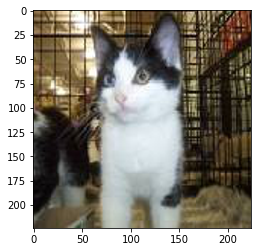

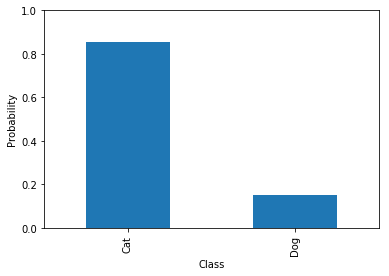

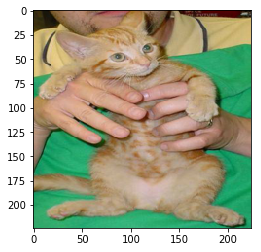

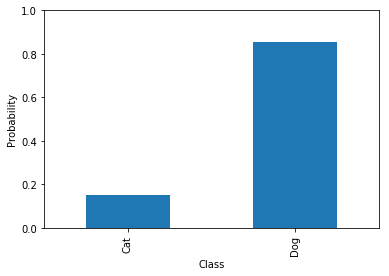

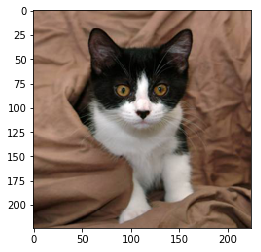

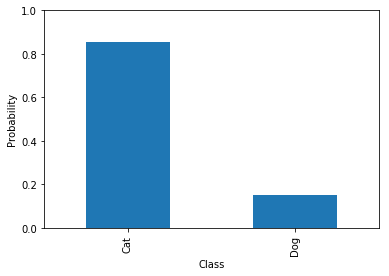

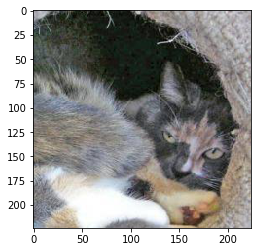

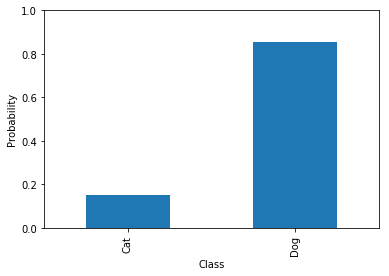

In [59]:
show_prediction_examples(num_examples=4, validation_image_generator=validation_generator, model=model, folder_path=timestamp, model_name='mymodel')

Loop through every validation image and calculate target (actual) class and class predicted by the model

In [96]:
PREDICTION_CUTOFF = 0.5
predcls = []
targetcls = []
CAT_VAL = 0
DOG_VAL = 1
for (dirpath, dirs, files) in os.walk(DATASET_PATH + '/validation'):
    for file in files:
        img_val = CAT_VAL
        if 'dog' in dirpath:
            img_val = DOG_VAL
        filepath = os.path.join(dirpath, file)
        img = plt.imread(filepath)
        #manually resize the image to the expected size
        resized_img = sktransform.resize(img, IMAGE_SIZE)
        #DEBUG, show image
        #plt.imshow(img)
        #plt.show()
        #plt.imshow(resized_img)
        #plt.show()

        #the first dimension is the batch size
        #we need to add that extra dimension and rescale the image from 0-255 down to 0-1
        batched_img = np.expand_dims(resized_img, axis=0)/255

        prediction = model.predict(batched_img)
        #DEBUG, show numpy array and prediction output array
        #print(batched_img)
        #print(prediction)

        targetcls.append(img_val)
        pred_val = DOG_VAL if (prediction[0][0] >= PREDICTION_CUTOFF) else CAT_VAL
        predcls.append(pred_val)
        print(filepath + ' img_val: ' + str(img_val) + ' predict: ' + str(prediction[0][0]) + ' pred_val: ' + str(pred_val))

./dataset/validation/cats/cat.1350.jpg img_val: 0 predict: 0.19776078 pred_val: 0
./dataset/validation/cats/cat.1017.jpg img_val: 0 predict: 0.19838019 pred_val: 0
./dataset/validation/cats/cat.1154.jpg img_val: 0 predict: 0.19761549 pred_val: 0
./dataset/validation/cats/cat.1292.jpg img_val: 0 predict: 0.1954165 pred_val: 0
./dataset/validation/cats/cat.1352.jpg img_val: 0 predict: 0.19569264 pred_val: 0
./dataset/validation/cats/cat.1252.jpg img_val: 0 predict: 0.19797273 pred_val: 0
./dataset/validation/cats/cat.1011.jpg img_val: 0 predict: 0.19673096 pred_val: 0
./dataset/validation/cats/cat.1138.jpg img_val: 0 predict: 0.19719382 pred_val: 0
./dataset/validation/cats/cat.1370.jpg img_val: 0 predict: 0.19711316 pred_val: 0
./dataset/validation/cats/cat.1287.jpg img_val: 0 predict: 0.19629076 pred_val: 0
./dataset/validation/cats/cat.1251.jpg img_val: 0 predict: 0.1955341 pred_val: 0
./dataset/validation/cats/cat.1308.jpg img_val: 0 predict: 0.19894993 pred_val: 0
./dataset/validati

Show the confusion matrix
                      predicted
                 0 (cat)    1 (dog)
actual 0 (cat)
       1 (dog)
```

In [97]:
cm = skmetrics.confusion_matrix(targetcls, predcls)
cm

array([[400,   0],
       [400,   0]])